# Sentinel-2 MSI Level 2A - Composite Imagery, Normalized Burn Ratio and Burn Severity

```{hint} 
<a href='https://fire.ltpy.adamplatform.eu/hub/user-redirect/lab/tree/med_part3_workflows/figure2345_Sentinel-2.ipynb' target='_blank'>Execute the notebook on the training platform >></a>
```

This notebook provides you an introduction to data from the [Sentinel-2 MultiSpectral Instrument (MSI)](https://sentinel.esa.int/web/sentinel/missions/sentinel-2/instrument-payload), which has has 13 spectral bands which provide data for land cover/change classification, atmospheric correction and cloud/snow separation. This notebook demonstrates several ways that Level 2A data from Sentinel-2 can be used, including the creation of composite imagery, calculation of a burn index and burn severity mapping. 

The events featured in this notebook are the wildfires in Italy and Greece in summer 2021. The image below shows the active burning on the Evia island of Greece on 8 August 2021, recorded by the Sentinel 2 MSI.

```{figure} img/20210809_EviaWildfire.jpg
:width: 70%
:name: Wildfires on the island of Evia, Greece in August 2021
Wildfires on the island of Evia, Greece in August 2021 (Source: <a href='https://www.copernicus.eu/en/media/image-day-gallery/evia-wildfire-greece' target='_blank'> Copernicus</a>)
``` 

``` {admonition} Basic Facts
**Spatial resolution**: `10m, 20m and 60m`<br>
**Spatial coverage**: `Global` <br>
**Revisit time**: `5 days at the equator` <br>
**Data availability**: `since Mar 2017`
```

``` {admonition} How to access the data
Sentinel-2 Level 2A data can be obtained via the <a href='https://dataspace.copernicus.eu/' target='_blank'>Copernicus Open Access Hub</a> and are disseminated as `.zip archives` when downloaded. You need to register for an account before downloading data.

The data when unzipped, are in "SENTINEL-SAFE format, including image data in JPEG2000 format, quality indicators (e.g. defective pixels mask), auxiliary data and metadata." <a href='https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/data-formats' target='_blank'>Learn more about the data format here.</a>
```

<hr>

**Load required libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import glob as glob

# Python libraries for visualization
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.cm import get_cmap
from matplotlib.axes import Axes
from skimage import exposure
import rasterio
from rasterio import plot
from rasterio.plot import show

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
warnings.simplefilter(action = "ignore", category = UserWarning)

**Load helper functions**

In [2]:
%run ../functions.ipynb

<hr>

## Load and browse the Sentinel-2 MSI data

### [Optional] Unzip the downloaded Sentinel-2 zipped archives

Here are files from two dates for monitoring before and after the fire. The dates are as follows: 
* **1 August 2021**: before the ignition of the fires
* **25 September 2021**: after the extinguishing of the fires

The first step is to use the zipfile library to unzip and extract the contents of the two zipped archives downloaded. You need to pass in the file paths of the zip file an input to the `.ZipFile()` function as well as `r` which stands for read. This step is optional as we have already unzipped the file for you. This is why the code is commented out.

You also need to pass in the path to the folder where you want to store the unzipped contents to the `.extractall()` function.

In [3]:
# import zipfile
# with zipfile.ZipFile('../data/sentinel-2/2021/08/01/S2B_MSIL2A_20210801T092029_N0301_R093_T34SFJ_20210801T114000.zip', 'r') as zip_ref:
#    zip_ref.extractall('../data/sentinel-2/2021/08/01/')

In [4]:
# with zipfile.ZipFile('../data/sentinel-2/2021/09/25/S2A_MSIL2A_20210925T092031_N0301_R093_T34SFJ_20210925T124522.zip', 'r') as zip_ref:
#    zip_ref.extractall('../data/sentinel-2/2021/09/25/')

A SENTINEL-2 product refers to a directory folder that contains a collection of information. Upon unzipping you will see that it includes:

- a `manifest.safe` file which holds the general product information in XML
- a `preview image` in JPEG2000 format
- `GRANULE`: subfolders for measurement datasets including image data (granules/tiles) in GML-JPEG2000 format
- `DATASTRIP`: subfolders for datastrip level information
- `AUX_DATA`: a subfolder with auxiliary data (e.g. International Earth Rotation & Reference Systems (IERS) bulletin)
- `HTML`: HTML previews
- `rep_info`

The image data is contained several levels down within the `GRANULE` folder. A granule or tile is a 100x100 km<sup>2</sup> ortho-image in the UTM/WGS84 projection.

(workflow:med_part3_fig2)=
## Natural colour composites

### Natural colour composite from 1 August 2021

Natural colour composites assign the red, green and blue channels of image to show the corresponding visible red, visible green and visible blue bands of the satellite data. The recipe for the natural colour composites is as follows: Red-Green-Blue 4-3-2. Band 4, 3 and 2 have a native resolution of 10m. You can define the file path leading to the `R10m` folder and save it as a variable called `aug_r10`.

You can use the Python library [rasterio](https://rasterio.readthedocs.io/en/latest/) to open the Sentinel-2 MSI `jp2` format data using the function `rasterio.open()`. You need to pass in the file path containing the name of the file as a parameter.  

You then do this for all the files for the three bands you will use to make the composite.

In [5]:
aug_r10 = '../data/sentinel-2/2021/08/01/S2B_MSIL2A_20210801T092029_N0301_R093_T34SFJ_20210801T114000.SAFE/GRANULE/L2A_T34SFJ_A022999_20210801T092029/IMG_DATA/R10m/'

band2=rasterio.open(aug_r10 + "T34SFJ_20210801T092029_B02_10m.jp2")
band3=rasterio.open(aug_r10 + "T34SFJ_20210801T092029_B03_10m.jp2")
band4=rasterio.open(aug_r10 + "T34SFJ_20210801T092029_B04_10m.jp2")

Next, you can extract the metadata associated with a single band and update it to have a `count` of 3, as the resulting natural colour composite will have 3 bands at the end.

In [6]:
meta = band2.meta
meta.update({"count": 3})

Define a destination image path where you will write (`w`) the resulting natural colour composite image to as a `tif` file. You can add metadata to the composite image using `**meta`. Finally, you can write the first and only band from `band2`, `band3` and `band4` to the destination image. You can also specify the order of these bands. In the following code block, you designated `band2` as the first band, followed by `band3` and `band4`. 

In [7]:
prefire_rgb_path = 'rasterio/2021-08-01_S2_RGB.tif'

with rasterio.open(prefire_rgb_path, 'w', **meta) as dest:
    dest.write(band2.read(1),1)
    dest.write(band3.read(1),2)
    dest.write(band4.read(1),3)

Now, you can open the `tif` file that you just created.

In [8]:
img = rasterio.open(prefire_rgb_path)

Next, the image can be read in as one numpy array per band and inspect the shape of the overall array.

In [9]:
image = np.array([img.read(3), img.read(2), img.read(1)])
image.shape

(3, 10980, 10980)

The shape of the array is `(3, 10980, 10980)`. Note that the interpretation of the 3 axes shown in the shape is `(bands, rows, columns)`. This means you have to transpose the array and add index=0 on index position 3.

In [10]:
image = image.transpose(1,2,0)

In a subsequent step, you then scale the values to the range between 0 and 1, clipping the lower and upper 2 percentiles so that a potential contrast decrease caused by outliers is eliminated. This uses the `exposure.rescale_intensity()` function from the [scikit-image](https://scikit-image.org/) library.


In [11]:
p2, p98 = np.percentile(image, (2,98))
image = exposure.rescale_intensity(image, in_range=(p2, p98)) / 100000

Finally, you can plot the natural color composite with the matplotlib library.

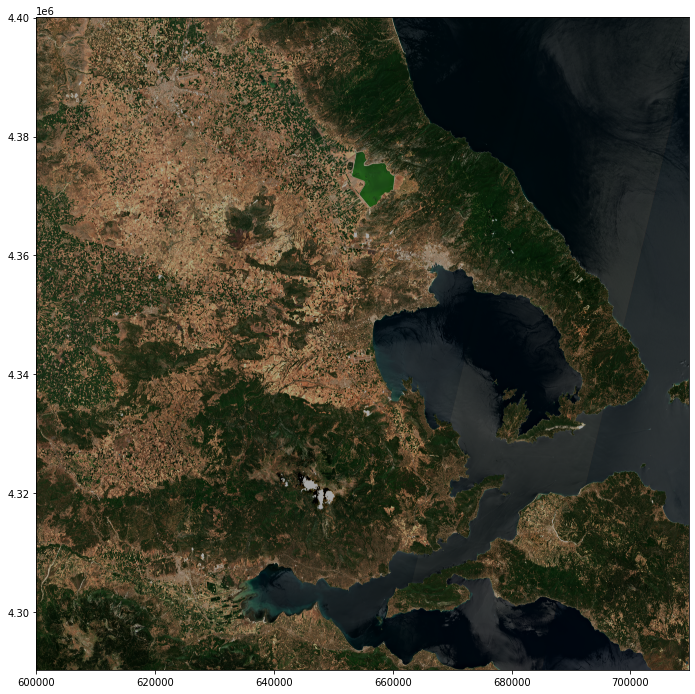

<AxesSubplot:>

In [12]:
# Define a plot
fig = plt.figure(figsize=(20,12))

# Show the figure
show(image.transpose(2,0,1), transform=img.transform)

### Natural colour composite from 25 September 2021

You can repeat the same steps to create the natural colour composite from 25 September 2021.

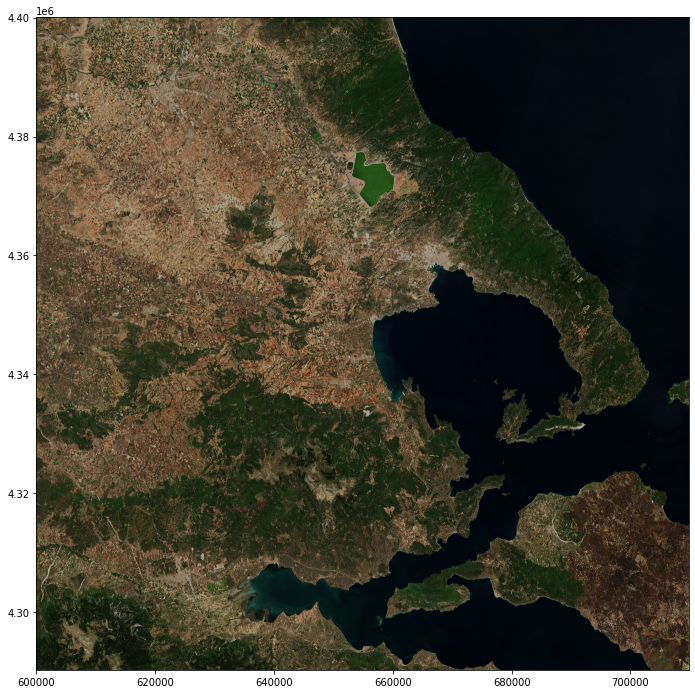

<AxesSubplot:>

In [13]:
#Define the folder path where the images are stored
sept_r10 = '../data/sentinel-2/2021/09/25/S2A_MSIL2A_20210925T092031_N0301_R093_T34SFJ_20210925T124522.SAFE/GRANULE/L2A_T34SFJ_A032694_20210925T092343/IMG_DATA/R10m/'

# Open b2, b3 and b4
band2=rasterio.open(sept_r10 + "T34SFJ_20210925T092031_B02_10m.jp2")
band3=rasterio.open(sept_r10 + "T34SFJ_20210925T092031_B03_10m.jp2")
band4=rasterio.open(sept_r10 + "T34SFJ_20210925T092031_B04_10m.jp2")

# Extract and update the metadata
meta = band2.meta
meta.update({"count": 3})

# Write the natural colour composite image with metadata
postfire_rgb_path = 'rasterio/2021-09-25_S2_RGB.tif'

with rasterio.open(postfire_rgb_path, 'w', **meta) as dest:
    dest.write(band2.read(1),1)
    dest.write(band3.read(1),2)
    dest.write(band4.read(1),3)

# Transpose and rescale the image 
img = rasterio.open(postfire_rgb_path)
image = np.array([img.read(3), img.read(2), img.read(1)]).transpose(1,2,0)
p2, p98 = np.percentile(image, (2,98))
image = exposure.rescale_intensity(image, in_range=(p2, p98)) / 100000

# Plot the resulting image
fig = plt.figure(figsize=(20,12))
show(image.transpose(2,0,1), transform=img.transform)

```{admonition} Return to the case study
Assessing post-fire impacts with next-generation satellites: Mediterranean Fires Case Study <br>
[](med_part3_fig2)
```

(workflow:med_part3_fig3)=
## False colour composites

### False colour composite from 1 August 2021

You can use a false colour composite to makes burn scars more easily distinguishable. The recipe for the false colour composite is: `Red-Green-Blue 12-8A-2`. This means that the `red` channel was assigned to `band 12` (shortwave infrared), the `green` channel was assigned to `band 8A` (near-infrared) and the `blue` channel was assigned to `band 2` (the visible blue band). As bands 8A and 12 have a 20m resolution, you can define the file path leading to the `R20m` folder and save it as a variable called `aug_r20`. The visible red band has also been resampled to 20m in this folder.

You can use the Python library [rasterio](https://rasterio.readthedocs.io/en/latest/) to open the Sentinel-2 MSI `jp2` format data using the function `rasterio.open()`. You need to pass in the file path containing the name of the file as a parameter.  

You then do this for all the files for the three bands you will use to make the composite.

In [14]:
aug_r20 = '../data/sentinel-2/2021/08/01/S2B_MSIL2A_20210801T092029_N0301_R093_T34SFJ_20210801T114000.SAFE/GRANULE/L2A_T34SFJ_A022999_20210801T092029/IMG_DATA/R20m/'

band12=rasterio.open(aug_r20 + "T34SFJ_20210801T092029_B12_20m.jp2")
band8a=rasterio.open(aug_r20 + "T34SFJ_20210801T092029_B8A_20m.jp2")
band2=rasterio.open(aug_r20 + "T34SFJ_20210801T092029_B02_20m.jp2")

Next, you can extract the metadata associated with a single band and update it to have a `count` of 3, as the resulting natural colour composite will have 3 bands at the end.

In [15]:
meta = band2.meta
meta.update({"count": 3})

Define a destination image path where you will write (`w`) the resulting natural colour composite image to as a `tif` file. You can add metadata to the composite image using `**meta`. Finally, you can write the first and only band from `band2`, `band3` and `band4` to the destination image. You can also specify the order of these bands. In the following code block, you designated `band2` as the first band, followed by `band3` and `band4`. 

In [16]:
prefire_false_rgb_path = 'rasterio/2021-08-01_S2_burnscar_RGB.tif'

with rasterio.open(prefire_false_rgb_path, 'w', **meta) as dest:
    dest.write(band2.read(1),1)
    dest.write(band8a.read(1),2)
    dest.write(band12.read(1),3)

Now, you can open the `tif` file that you just created.

In [17]:
img = rasterio.open(prefire_false_rgb_path)

Next, the image can be read in as one numpy array per band and inspect the shape of the overall array.

In [18]:
image = np.array([img.read(3), img.read(2), img.read(1)])
image.shape

(3, 5490, 5490)

The shape of the array is `(3, 5490, 5490)`. Note that the interpretation of the 3 axes shown in the shape is `(bands, rows, columns)`. This means you have to transpose the array and add index=0 on index position 3.

In [19]:
image = image.transpose(1,2,0)

In a subsequent step, you then scale the values to the range between 0 and 1, clipping the lower and upper 2 percentiles so that a potential contrast decrease caused by outliers is eliminated. This uses the `exposure.rescale_intensity()` function from the [scikit-image](https://scikit-image.org/) library.


In [20]:
p2, p98 = np.percentile(image, (2,98))
image = exposure.rescale_intensity(image, in_range=(p2, p98)) / 100000

Finally, you can plot the resulting false color composite with the matplotlib library.

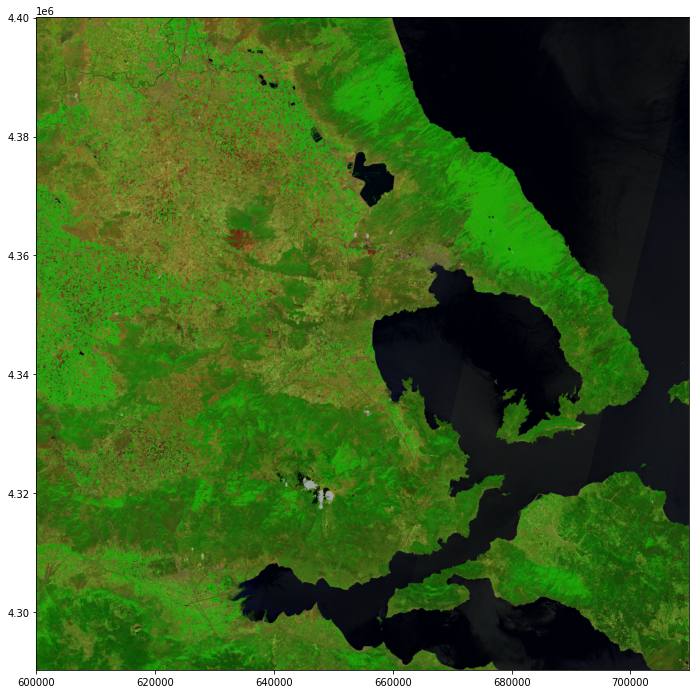

<AxesSubplot:>

In [21]:
# Define a plot
fig = plt.figure(figsize=(20,12))

# Show the figure
show(image.transpose(2,0,1), transform=img.transform)

### False colour composite from 25 September 2021

You can repeat the same steps to create the false colour composite from 25 September 2021.

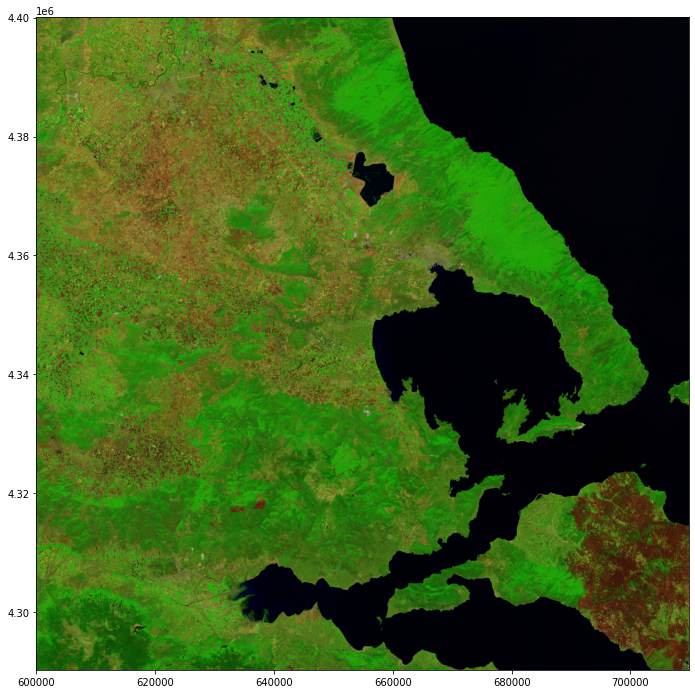

<AxesSubplot:>

In [22]:
#Define the folder path where the images are stored
sept_r20 = '../data/sentinel-2/2021/09/25/S2A_MSIL2A_20210925T092031_N0301_R093_T34SFJ_20210925T124522.SAFE/GRANULE/L2A_T34SFJ_A032694_20210925T092343/IMG_DATA/R20m/'

# Open b2, b8a and b12
band12=rasterio.open(sept_r20 + "T34SFJ_20210925T092031_B12_20m.jp2")
band8a=rasterio.open(sept_r20 + "T34SFJ_20210925T092031_B8A_20m.jp2")
band2=rasterio.open(sept_r20 + "T34SFJ_20210925T092031_B02_20m.jp2")

# Extract and update the metadata
meta = band2.meta
meta.update({"count": 3})

# Write the false colour composite image with metadata
postfire_false_rgb_path = 'rasterio/2021-09-25_S2_burnscar_RGB.tif'

with rasterio.open(postfire_false_rgb_path, 'w', **meta) as dest:
    dest.write(band2.read(1),1)
    dest.write(band8a.read(1),2)
    dest.write(band12.read(1),3)

# Transpose and rescale the image 
img = rasterio.open(postfire_false_rgb_path)
image = np.array([img.read(3), img.read(2), img.read(1)]).transpose(1,2,0)
p2, p98 = np.percentile(image, (2,98))
image = exposure.rescale_intensity(image, in_range=(p2, p98)) / 100000

# Plot the resulting image
fig = plt.figure(figsize=(20,12))
show(image.transpose(2,0,1), transform=img.transform)

```{admonition} Return to the case study
Assessing post-fire impacts with next-generation satellites: Mediterranean Fires Case Study <br>
[](med_part3_fig3)
```

(workflow:med_part3_fig4)=
## Normalized Burn Ratio (NBR) and Differenced NBR images

As explained by [UN SPIDER](https://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/burn-severity-earth-engine), the Normalized Burn Ratio “uses near-infrared (NIR) and shortwave-infrared (SWIR) wavelengths. Healthy vegetation before the fire has very high NIR reflectance and a low SWIR response. In contrast, recently burned areas have a low reflectance in the NIR and high reflectance in the SWIR band.” The formula is `NBR = (NIR - SWIR) / (NIR + SWIR)` or using the MSI band numbers: `NBR = (B8A - B12) / (B8A + B12)`. 

### NBR on 1 August 2021 (pre-fire)

As bands 8A and 12 have a 20m resolution, you can reuse the variable containing the path to the `R20m` folder, `aug_r20`.

You can use the Python library [rasterio](https://rasterio.readthedocs.io/en/latest/) to open the Sentinel-2 MSI `jp2` format data using the function `rasterio.open()`. You need to pass in the file path containing the name of the file as a parameter.  You then do this for both bands you will use to calculate the NBR.

In [23]:
b8a=rasterio.open(aug_r20 + "T34SFJ_20210801T092029_B8A_20m.jp2")
b12=rasterio.open(aug_r20 + "T34SFJ_20210801T092029_B12_20m.jp2")

Next, you can read in the NIR and SWIR bands.

In [24]:
swir = b12.read()
nir = b8a.read()

The next step is to calculate the NBR image using the formula described above. 

In [25]:
nbr = (nir.astype(float)-swir.astype(float))/(nir+swir)

Next, you can extract the metadata associated with a single band and update the driver to `GTiff`, and the data type to `float32`.

In [26]:
meta = b12.meta
meta.update(driver='GTiff')
meta.update(dtype=rasterio.float32)

Define a destination image path where you will write (`w`) the resulting NBR image to as a `tif` file. You can add metadata to the NBR image using `**meta`. Finally, you can write the NBR image to the destination image path with the data type set to `float32`. 

In [27]:
prefire_nbr_path = 'rasterio/2021-08-01_S2_NBR.tif'

with rasterio.open(prefire_nbr_path, 'w', **meta) as dest:
    dest.write(nbr.astype(rasterio.float32))

Now, you can open and read in the `tif` file that you just created as a numpy array.

In [28]:
img = rasterio.open(prefire_nbr_path)
img_r = img.read()
image = np.asarray(img_r)

Finally, you can plot the resulting NBR image with the matplotlib library.

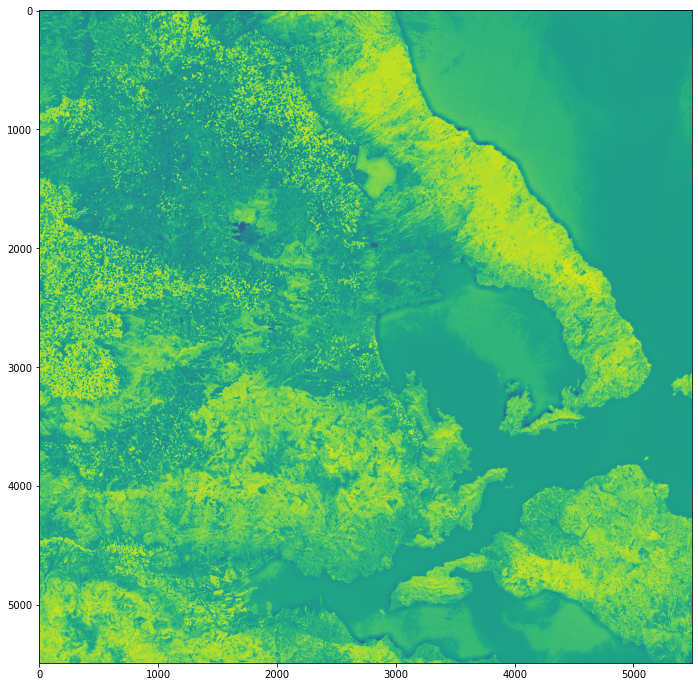

<AxesSubplot:>

In [29]:
# Define a plot
fig = plt.figure(figsize=(20,12))

# Show the figure
show(image)

### NBR on 25 September 2021 (post-fire)

You can repeat the same steps to create the NBR image from 25 September 2021.

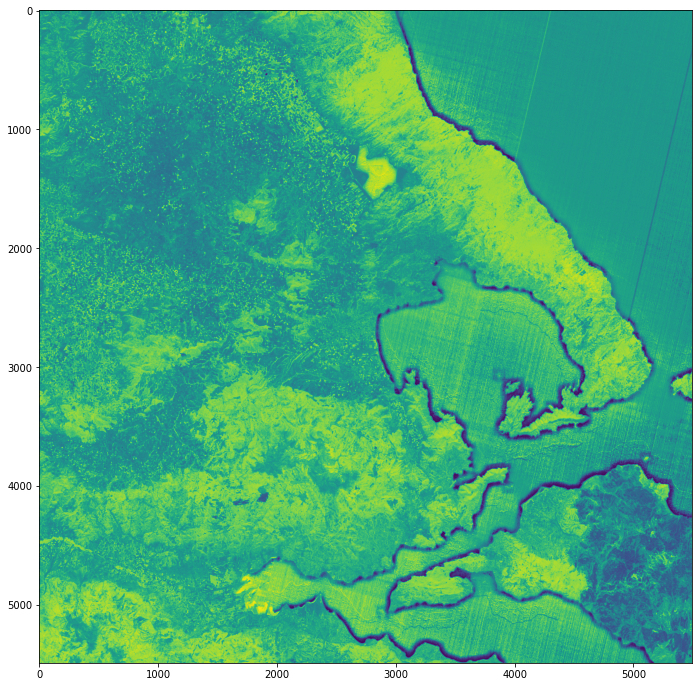

<AxesSubplot:>

In [30]:
# Open b8a and b12
b8a=rasterio.open(sept_r20 + "T34SFJ_20210925T092031_B8A_20m.jp2")
b12=rasterio.open(sept_r20 + "T34SFJ_20210925T092031_B12_20m.jp2")

# read NIR(b8a) and SWIR(b12) as arrays
swir = b12.read()
nir = b8a.read()

# Calculate NBR
nbr = (nir.astype(float)-swir.astype(float))/(nir+swir)

# Extract and update the metadata
meta = b12.meta
meta.update(driver='GTiff')
meta.update(dtype=rasterio.float32)

# Write the NBR image with metadata
postfire_nbr_path = 'rasterio/2021-09-25_S2_NBR.tif'

with rasterio.open(postfire_nbr_path, 'w', **meta) as dest:
    dest.write(nbr.astype(rasterio.float32))
    
# Open and read the image
img = rasterio.open(postfire_nbr_path)
img_r = img.read()
image = np.asarray(img_r)

# Plot the resulting image
fig = plt.figure(figsize=(20,12))
show(image)

### Differenced NBR (pre-fire minus post-fire NBR)

Next, we can calculate the differenced NBR image (also known as dNBR) by subtracting the post-fire NBR from the pre-fire NBR image. Higher dNBR values indicate higher burn severity.

The first step is to open the pre- and post-fire NBR images with the `.open()` function from the rasterio library. Then, you can read them in as arrays with the `.read()` function.

In [31]:
# Open NBR images from 1 August 2021 (pre-fire) and 25 September 2021 (post-fire)
pre_nbr = rasterio.open(prefire_nbr_path)
post_nbr = rasterio.open(postfire_nbr_path)

# Read the images in as arrays
pre = pre_nbr.read()
post = post_nbr.read()

Next, you can calculate the dNBR image by subtracting the post-fire image from the pre-fire image. You can cast both images with type `.float32` to to ensure that your dNBR output also has the same type. 

In [32]:
dnbr = pre.astype(rasterio.float32)-post.astype(rasterio.float32)

Next, you can extract the metadata associated with a single band and update the driver to `GTiff`, and the data type to `float32`.

In [33]:
meta = pre_nbr.meta
meta.update(driver='GTiff')
meta.update(dtype=rasterio.float32)

Define a destination image path where you will write (`w`) the resulting dNBR image to as a `tif` file. You can add metadata to the dNBR image using `**meta`. Finally, you can write the NBR image to the destination image path with the data type set to `float32`. 

In [34]:
dnbr_path = 'rasterio/2021-08-01_sub_2021-09-25_S2_dNBR.tif'

with rasterio.open(dnbr_path, 'w', **meta) as dest:
    dest.write(dnbr.astype(rasterio.float32))

Now, you can open and read in the `tif` file that you just created as a numpy array.

In [35]:
# Rescale the image
img = rasterio.open(dnbr_path)
img_r = img.read()
image = np.asarray(img_r)

Finally, you can plot the resulting dNBR image with the matplotlib library.

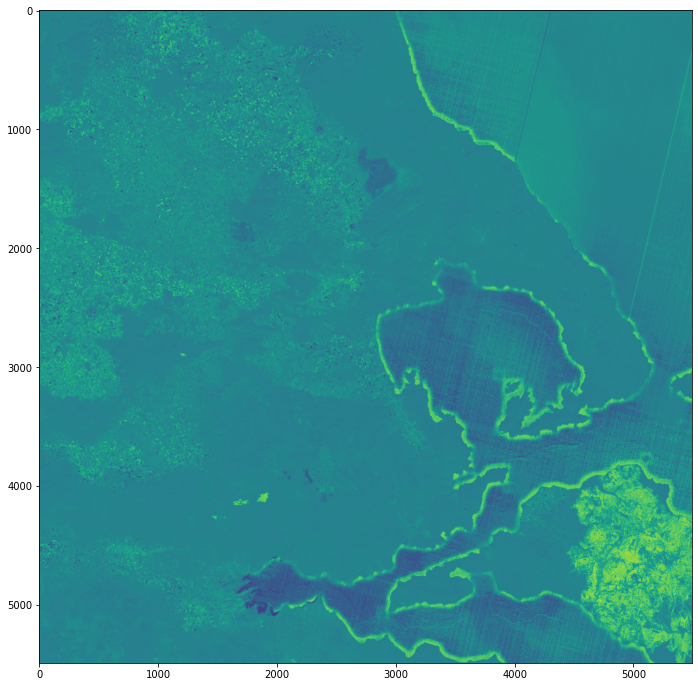

<AxesSubplot:>

In [36]:
fig = plt.figure(figsize=(20,12))
show(image)

```{admonition} Return to the case study
Assessing post-fire impacts with next-generation satellites: Mediterranean Fires Case Study <br>
[](med_part3_fig4)
```

(workflow:med_part3_fig5)=
## Burn Severity Map

The dNBR image you calculated can be used for assessing burn severity after a fire. According to [UN SPIDER](https://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/burn-severity-earth-engine), "areas with higher dNBR values indicate more severe damage whereas areas with negative dNBR values might show increased vegetation productivity. dNBR can be classified according to burn severity ranges proposed by the United States Geological Survey (USGS)."

You can begin by first preparing a water mask using the Scene Classification Layer which is also included in the `IMG_DATA` provided to you. You can use the 20m resolution image to match the dNBR's resolution. 

### Create water mask using Scene Classification Layer (20m resolution)

First, use the `.open()` function from the rasterio library to open the image. You can reuse the `sept_r20` variable that holds the file path to the image data from 25 September 2021.

In [37]:
scl_image = rasterio.open(sept_r20 + "T34SFJ_20210925T092031_SCL_20m.jp2")

Then, you can read them in as arrays with the `.read()` function. When printing the resulting array, you will see that it contains integers. Each integer represents a different [classification](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm#:~:text=Figure%203%3A%20Scene%20Classification%20Values). For example:
- `2` indicates dark area pixels
- `4` indicates vegetation 
- `5` indicates non-vegetated pixels 
- `6` indicates water pixels

In [38]:
scl = scl_image.read()
scl = np.array(scl)
scl

array([[[5, 4, 5, ..., 6, 6, 6],
        [5, 5, 5, ..., 6, 6, 6],
        [5, 5, 5, ..., 6, 6, 6],
        ...,
        [4, 4, 4, ..., 5, 5, 5],
        [4, 4, 4, ..., 5, 5, 5],
        [4, 4, 4, ..., 5, 5, 5]]], dtype=uint8)

As water pixels have a value of 6, you can replace all pixels with all other values with `nan` using the `.where()` function from the numpy library.

In [39]:
water = np.where(scl != 6, np.nan, scl)
water

array([[[nan, nan, nan, ...,  6.,  6.,  6.],
        [nan, nan, nan, ...,  6.,  6.,  6.],
        [nan, nan, nan, ...,  6.,  6.,  6.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])

You can plot the figure to take a look at the water pixels.

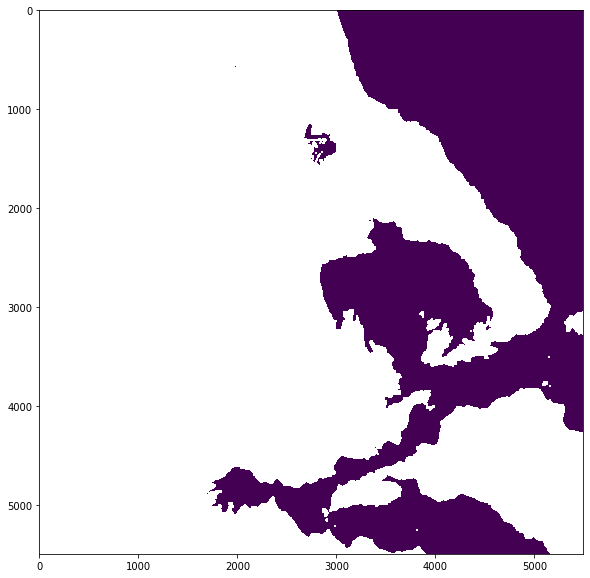

<AxesSubplot:>

In [40]:
fig = plt.figure(figsize=(10,10))
show(water)

Next, you can extract the metadata associated with a single band and update the driver to `GTiff`, and the data type to `float32`.

In [41]:
meta = scl_image.meta
meta.update(driver='GTiff')
meta.update(dtype=rasterio.float32)

Define a destination image path where you will write (`w`) the resulting water mask image to as a `tif` file. You can add metadata to the dNBR image using `**meta`. Finally, you can write the NBR image to the destination image path with the data type set to `float32`. 

In [42]:
water_path = 'rasterio/2021-09-25_S2_water.tif'

with rasterio.open(water_path, 'w', **meta) as dest:
    dest.write(water.astype(rasterio.float32))

### Classify the dNBR raster using the burn severity classification table

The dNBR image can be classified according to burn severity ranges proposed by the United States Geological Survey (USGS), as shown in the table below.

```{figure} img/dnbr_class_table.png
:width: 70%
:name: dNBR Class Table
:align: center
dNBR Class Table (Source: <a href='https://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio' target='_blank'> USGS</a>)
``` 

To prepare for classification, you need to open and read in the dNBR image that you created earlier using the `.open()` and `.read()` functions of the rasterio library. Then, you convert the image to a numpy array using `np.asarray()` and multiply the array by 1000 to rescale it as shown in the middle column of the classification table above.

In [43]:
img = rasterio.open(dnbr_path)
img_r = img.read(1)
image = np.asarray(img_r)*1000

You can also open, read in and convert the water mask image into a numpy array.

In [44]:
water_img = rasterio.open(water_path)
water_r = water_img.read(1)
water = np.asarray(water_r)

You can make use of the `ListedColorMap` function from the matplotlib library to define the colors for each class.

In [45]:
#set colours for plotting and classes
cmap = ListedColormap([[122/255., 135/255., 55/255.],
                          [172/255., 190/255., 77/255.],
                          [10/255., 224/255., 66/255.],
                          [255/255., 247/255., 11/255.],
                          [255/255., 175/255., 56/255.],
                          [255/255., 100/255., 27/255.],
                          [164/255., 31/255., 214/255.],
                          [255/255., 255/255., 255/255.]])

Next, referring to the classification table above, you can define the levels for the respective burn severity classes in a list stored in the variable `bounds`. You can also use the `.BoundaryNorm()` function from `matplotlib.colors` to define the norm that you will use for plotting later. 

In [46]:
bounds = [-1000, -251, -101, 99, 269, 439, 659, 1300, 2000]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)  

Finally, you can plot the image with the following steps: 
- Define the figure
- Use `.imshow()` to plot the dNBR image with the custom colormap and norm
- Add the water mask image to the figure using `.imshow()`
- Add a figure title
- Add a colorbar 
- Set the tick labels to reflect the burn severity classes
- Show the plot

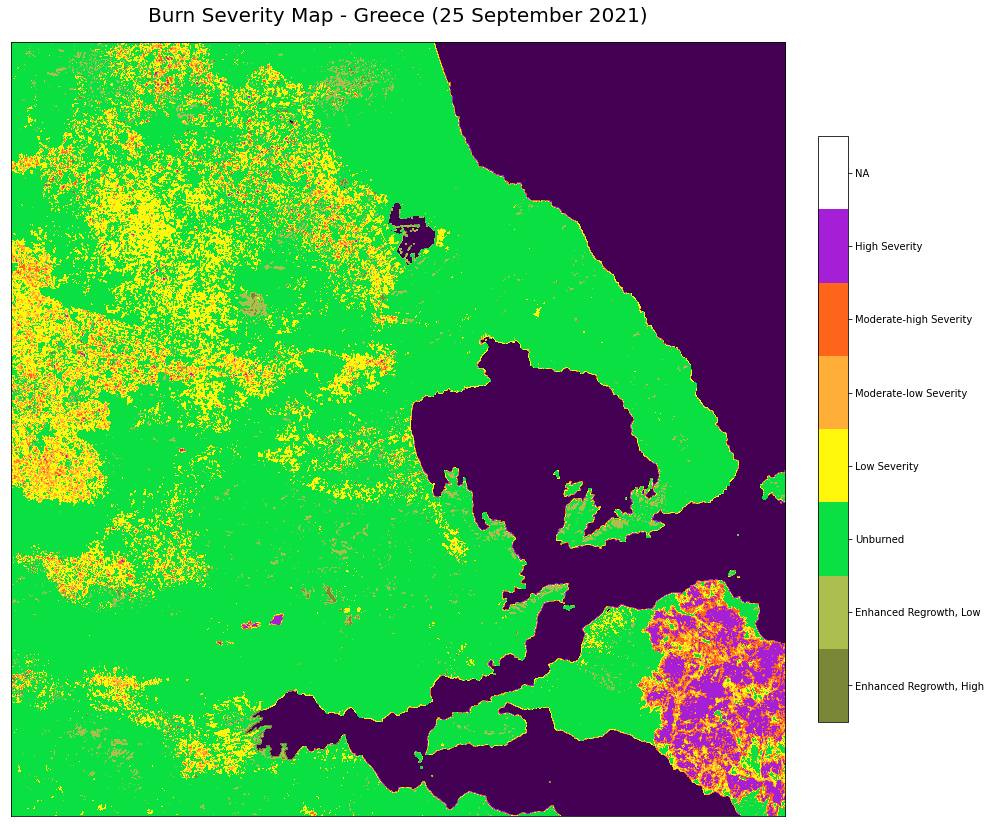

In [47]:
# Define the figure
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'xticks': [], 'yticks': []})

# Use `.imshow()` to plot the dNBR image with the custom colormap and norm
cax = ax.imshow(image, cmap=cmap, norm = norm)

# Add the water mask image to the figure using `.imshow()`
ax.imshow(water)

# Add a figure title
plt.title('Burn Severity Map - Greece (25 September 2021)', fontsize=20, pad=20.0)

# Add a colorbar 
cbar = fig.colorbar(cax, ax=ax, fraction=0.035, pad=0.04, ticks=[-625, -176, -1, 184, 354, 549, 980, 1650])

# Set the tick labels to reflect the burn severity classes
cbar.ax.set_yticklabels(['Enhanced Regrowth, High',
         'Enhanced Regrowth, Low',
         'Unburned', 
         'Low Severity', 
         'Moderate-low Severity', 
         'Moderate-high Severity', 
         'High Severity', 
         'NA'])

# Show the plot
plt.show()

<hr>

### References
* Copernicus Sentinel data 2021

* Some code in this notebook was adapted from the following sources:
    * origin: https://gis.stackexchange.com/questions/341809/merging-sentinel-2-rgb-bands-with-rasterio
    * copyright: 2020, G.L.
    * license: CC BY-SA 4.0
    * retrieved: 2022-06-28 by Sabrina Szeto
    * origin: https://github.com/UN-SPIDER/burn-severity-mapping-EO/blob/master/burn_severity.ipynb
    * copyright: 2018, UN SPIDER
    * license: Public Domain
    * retrieved: 2022-06-28 by Sabrina Szeto

```{admonition} Return to the case study
Assessing post-fire impacts with next-generation satellites: Mediterranean Fires Case Study <br>
[](med_part3_fig5)
```